# Sevendi Eldrige Rifki Poluan🔥🔥🔥
### Descriptions: NLP Fundamental

In [4]:
# working environment
!nvidia-smi

Mon Apr 10 05:16:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   41C    P8               38W / 390W|    236MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color='red'>Import the necessary libraries</font>

In [186]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import glob
import itertools 
from sklearn.metrics import confusion_matrix
import re
import time
import json
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.12.0'

## <font color='red'>To begin, you can download the IMDB dataset which consists of 50,000 movie reviews. The dataset is divided into 25,000 reviews for training and 25,000 reviews for testing. For more detailed information about the dataset, you can refer to the official [page](https://ai.stanford.edu/~amaas/data/sentiment/) of the dataset.</font>

In [8]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-08 16:23:57--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  4.68MB/s    in 25s     

2023-04-08 16:24:22 (3.27 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [9]:
!ls aclImdb_v1.tar.gz

aclImdb_v1.tar.gz


In [12]:
!tar -xf aclImdb_v1.tar.gz

In [15]:
!ls aclImdb  

README	imdb.vocab  imdbEr.txt	test  train


In [47]:
!ls aclImdb/train

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [22]:
!cat aclImdb/train/neg/0_3.txt

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.

## <font color='red'>Let's generate a list of files by collecting all the existing text files in a folder.</font>

In [2]:
train_neg_list = glob.glob("aclImdb/train/neg/*.txt")
train_pos_list = glob.glob("aclImdb/train/pos/*.txt")

test_neg_list = glob.glob("aclImdb/test/neg/*.txt")
test_pos_list = glob.glob("aclImdb/test/pos/*.txt")

unsup_list = glob.glob("aclImdb/train/unsup/*.txt")
 

## <font color='red'>Now, I will implement a function to read the dataset from a text file in order to prepare the data for training and testing.</font>

        I would like to filter out sentences that contain HTML tags, as I noticed that some sentences still have these tags present.
        
        Furthermore, I would like to replace all digits with "@" in order to standardize the representation of digits in the sentences. 
        
        I will manually load the data from the files and store it in memory, as our current dataset is not very large. However, if the dataset grows significantly in size, this approach may not be feasible due to memory constraints, which could result in performance issues and potentially crash the process.

In [25]:
CLASS_LABEL = {'neg': 0, 'pos': 1}

In [26]:
def func(text):
    text = text.lower()
    text = re.sub(r"<br />", "", text) 
    text = re.sub(r"[\']", "", text)    
    text = ' ' . join(re.findall(r"[a-z0-9\.\!\"]+", text))
    text = re.sub(r"[0-9]+", " @ ", text)
    text = re.sub(r"[\.\!\"\?]+", " . ", text)  
    text = re.sub(r'\s+', " ", text).strip()  
    return text

In [27]:
def read_files(paths, label):
    datasets = {
        "text": [],
        "target": []
    }
    for path in paths:
        text = ' ' . join(open(path, 'r').readlines()) 
        datasets['text'].append(func(text))
        datasets['target'].append(CLASS_LABEL[label])
    return datasets

In [28]:
start_time = time.perf_counter()
neg_train_text = read_files(train_neg_list, 'neg')
pos_train_text = read_files(train_pos_list, 'pos')

neg_test_text = read_files(test_neg_list, 'neg')
pos_test_text = read_files(test_pos_list, 'pos')

unsup_text = read_files(unsup_list, 'pos')

end_time = time.perf_counter()
print("Running time:", end_time - start_time, "seconds")

Running time: 14.285688663017936 seconds


In [29]:
pd.DataFrame(pos_train_text).head()

,text,target
0,i sat down to watch . midnight cowboy . thinki...,1
1,i have to say that this miniseries was the bes...,1
2,this movie is a riot . i cannot remember the l...,1
3,one of the ten best comedies ever this seems a...,1
4,i had never heard of leos carax until his merd...,1


In [30]:
pd.DataFrame(pos_train_text).shape, pd.DataFrame(pos_train_text).shape

((12500, 2), (12500, 2))

In [54]:
train_text = pd.concat([pd.DataFrame(pos_train_text), pd.DataFrame(neg_train_text)], ignore_index=True).sample(frac=1.0, random_state=42)
test_text = pd.concat([pd.DataFrame(pos_test_text), pd.DataFrame(neg_test_text)], ignore_index=True).sample(frac=1.0, random_state=42)

In [32]:
train_text.shape

(25000, 2)

In [33]:
train_text.head()

,text,target
6868,one of the last great musicals of the @ s . i ...,1
24016,we had to go to an appointment so we turned on...,0
9668,while the title . before the devil knows youre...,1
13640,in my lit . class weve just finished the book ...,0
14018,i really enjoyed the first half hour of this m...,0


In [36]:
train_ds = tf.data.Dataset.from_tensor_slices((train_text.text, train_text.target))
test_ds = tf.data.Dataset.from_tensor_slices((test_text.text, test_text.target))

## <font color='red'>I will extract the sequence from the sentence and choose the one that appears most frequently in the training set. Specifically, I will select the sequence that occurs in the sentence with a frequency of 98 percent.</font>

In [37]:
print("Finding sequence ...")
start_time = time.perf_counter()
SEQS = [len(x.split(" ")) for x in train_text.text] 
end_time = time.perf_counter()
print("Execution time:", end_time - start_time, 'seconds') 

Finding sequence ...
Execution time: 0.22800252499291673 seconds


In [38]:
SEQ = int(np.percentile(SEQS, 98)) # 830
SEQ

830

In [39]:
SEQ = 830

## <font color='red'>Constructing the text vectorization for data preprocessing.</font>

    To avoid the time-consuming process of reloading and re-adapting the text vectorization, I will save it for future use.

In [62]:
print("Finding token length ...")
start_time = time.perf_counter()
MAX_TOKEN = len(set(' ' . join(list(train_text.text)) . split(" ")))
end_time = time.perf_counter()
print("Execution time:", end_time - start_time, 'seconds') 

Finding token length ...
Execution time: 0.6449048119829968 seconds


In [63]:
MAX_TOKEN = 78536

In [64]:
vectorize = tf.keras.layers.TextVectorization(max_tokens=MAX_TOKEN,
                                              output_mode="int",
                                              output_sequence_length=SEQ,
                                              split="whitespace", 
                                              input_shape=(None, ))

In [65]:
print("Adapting ...")
start_time = time.perf_counter()
vectorize.adapt(train_text.text, batch_size=32)
end_time = time.perf_counter()
print("Execution time:", end_time - start_time, 'seconds') # 5.266078312997706 seconds

Adapting ...
Execution time: 5.266078312997706 seconds


In [66]:
vocabulary = vectorize.get_vocabulary()
vocabulary[:10], vocabulary[-10:]

(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
 ['aachen',
  'aaawwwwnnn',
  'aaaugh',
  'aaah',
  'aaaarrgh',
  'aaaand',
  'aaaahhhhhhh',
  'aaaaatch',
  'aaaaah',
  'aaaaaaah'])

In [67]:
MAX_TOKEN = len(vocabulary)

In [68]:
with open('vocabulary.txt', 'w') as f:
    for word in vocabulary:
        f.write(word + '\n')

In [69]:
config = vectorize.get_config()
config

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 78536,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 830,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 78536}

In [70]:
with open('config.json', 'w') as f:
    json.dump(config, f)

In [71]:
!ls

README.md  aclImdb_v1.tar.gz  imdb.ipynb  imdb.py
aclImdb    config.json	      imdb.log	  vocabulary.txt


## <font color='red'>Now, I will load the configuration and vocabulary, and assign them to a new TextVectorization object.</font>

In [97]:
n_vocabulary = None
with open('vocabulary.txt', 'r') as f:
    n_vocabulary = [line.strip() for line in f.readlines()] 

In [98]:
n_vocabulary[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [99]:
n_config = None
with open('config.json', 'r') as f:
    n_config = json.load(f)

In [100]:
n_config

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': [None, None],
 'max_tokens': 78536,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 830,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 78536}

In [101]:
n_vectorize = tf.keras.layers.TextVectorization.from_config(n_config)

In [102]:
n_vectorize.set_vocabulary(n_vocabulary)

In [230]:
n_vectorize([train_text.text[0]])

<tf.Tensor: shape=(1, 830), dtype=int64, numpy=
array([[   10,  1791,   178,     6,   103,  2709,  2368,   529,     9,
           59,    27,   157,  3824,   121,   121,    17,    47,     5,
           58,   507,    96,   212,    37,     2,   121,     8,     2,
          168,  5540,    14,  2709,  2368,  4591,  2631,   376,  1916,
         3768,     8, 10721,  1509,   517,    18,    46,    23,   107,
          107,  3824,   519,    14,    70,    12,    25,  6142,   558,
        18457,  2965,  1364,    15,   108,  8555,   466,     4,  4247,
         2145,     5,    95,    89,  1062,    53,    14,    70,   631,
           10,   425,     5,   230,    11,    93,    42,   769,  6526,
          256,     9,    97,     7,    28,     5,    58,  2561,    36,
           10,   155,   531,    73,    37,  2709,  2368,    18,   187,
            4,   172,   140,    29,     4,  1282,    61,    70,    90,
            3,    70,   574,    16,    47,     5,     2,   115,   351,
            5,    30,    55, 

## <font color='red'>Now, let's create our embedding.</font>

In [104]:
embedding = tf.keras.layers.Embedding(input_dim=MAX_TOKEN,
                                      output_dim=256,
                                      input_length=SEQ)

In [105]:
embedding(n_vectorize([train_text.text[0]]))

<tf.Tensor: shape=(1, 830, 256), dtype=float16, numpy=
array([[[-0.010826,  0.03293 ,  0.01071 , ..., -0.01973 ,  0.03506 ,
          0.0255  ],
        [ 0.03134 ,  0.04446 ,  0.0404  , ...,  0.03656 , -0.0316  ,
          0.04837 ],
        [-0.01451 ,  0.0232  , -0.01034 , ...,  0.0357  , -0.0432  ,
         -0.02911 ],
        ...,
        [ 0.01808 ,  0.015175, -0.01266 , ..., -0.01752 ,  0.01381 ,
         -0.04404 ],
        [ 0.01808 ,  0.015175, -0.01266 , ..., -0.01752 ,  0.01381 ,
         -0.04404 ],
        [ 0.01808 ,  0.015175, -0.01266 , ..., -0.01752 ,  0.01381 ,
         -0.04404 ]]], dtype=float16)>

## <font color='red'>Let us proceed with the construction of our model.</font>

    In this implementation, an LSTM model with bidirectional layers will be used. This configuration enables the model to capture contextual information from both the past and the future of the input data. This can be particularly beneficial in tasks where the meaning of the current input is influenced by both the preceding and succeeding context.

In [209]:
def create_model():
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    
    inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
    x = n_vectorize(inputs)
    x = embedding(x) 
    x = tf.keras.layers.Conv1D(256, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(128, 3, padding="valid", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer='l2')(x)
    x = tf.keras.layers.Dense(1)(x)
    outputs = tf.keras.layers.Activation(activation="sigmoid", dtype=tf.float32)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    return model

In [210]:
model = create_model()
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 830)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 830, 256)          20105216  
                                                                 
 conv1d_29 (Conv1D)          (None, 828, 256)          196864    
                                                                 
 conv1d_30 (Conv1D)          (None, 826, 128)          98432     
                                                                 
 global_average_pooling1d_10  (None, 128)              0         
  (GlobalAveragePooling1D)                                

## <font color='red'>We will define callbacks for updating the learning rate, implementing early stopping if the model does not show improvement, and saving the model whenever there is a decrease in the training loss.</font>

In [211]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, factor, patience, min_lr):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.wait = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        
        # print('\rlr_logs: ', logs, '\r')
        print("\rwait: ", self.wait, "\r")
        print("\rCurrent lr:", tf.keras.backend.get_value(self.model.optimizer.lr), "\r")
        
        current_val_loss = logs['val_loss'] 
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            print("\rself.wait >= self.patience:", self.wait >= self.patience, "\r")
            if self.wait >= self.patience:
                old_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
                new_lr = old_lr * self.factor
                
                print("\rnew_lr >= self.min_lr:", new_lr >= self.min_lr, "\r")
                if new_lr >= self.min_lr:
                    print(f'\rEpoch {epoch+1}: Learning rate reduced to {new_lr} \r')
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) 
                else:
                    print(f'\rEpoch {epoch+1}: Minimum learning rate reached\r')
                self.wait = 0
                
lr_callback = CustomLearningRateScheduler(factor=0.1, 
                                          patience=5,
                                          min_lr=1e-7) 

In [212]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=4, # Number of epochs with no improvement after which training will be stopped.
                                               start_from_epoch=1,
                                               mode="min") # training will stop when the quantity monitored has stopped decreasing

In [213]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
        
        print('\rcurrent_val_loss: ', current_val_loss, '\r')
        print('\rsave_best_only: ', self.save_best_only, '\r')
        print('\rbest_val_loss: ', self.best_val_loss, '\r')
        print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path)
            print("\rModel has been saved!")
        else:
            print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            self.model.save_weights(self.model_path) 
            print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='checkpoint/save-model/', save_best_only=True)

## <font color='red'>Now, it is time to commence the training process of our model.</font>

In [214]:
BATCH_SIZE = 100

train = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [215]:
history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * 0.25, callbacks=[save_callbacks, es_callback, lr_callback])

Epoch 1/100


2023-04-10 13:32:21.429725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [25000]
	 [[{{node Placeholder/_1}}]]


250/250 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9799

2023-04-10 13:32:56.254814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [25000]
	 [[{{node Placeholder/_1}}]]


logs:  {'loss': 0.29065757989883423, 'accuracy': 0.9799200296401978, 'val_loss': 0.6951375007629395, 'val_accuracy': 0.8626984357833862} 
current_val_loss:  0.6951375007629395 
save_best_only:  True 
best_val_loss:  inf 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
250/250 [==============================] - 39s 151ms/step - loss: 0.2907 - accuracy: 0.9799 - val_loss: 0.6951 - val_accuracy: 0.8627
Epoch 2/100
logs:  {'loss': 0.029580658301711082, 'accuracy': 0.9983999729156494, 'val_loss': 0.7396005988121033, 'val_accuracy': 0.8666666746139526} 
current_val_loss:  0.7396005988121033 
save_best_only:  True 
best_val_loss:  0.6951375007629395 
current_val_loss < best_val_loss:  False 
Saving weights at (save_best_only=False):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
self.wait >= self.patience: False 
250/250 [==============================] - 

## <font color='red'>The early stopping mechanism has proven to be effective in halting the training process before reaching the maximum number of epochs. It automatically stops training if there are no improvements in validation loss for four consecutive epochs, as configured. Now, let's proceed to evaluate our trained model using the testing data.</font>

<Axes: >

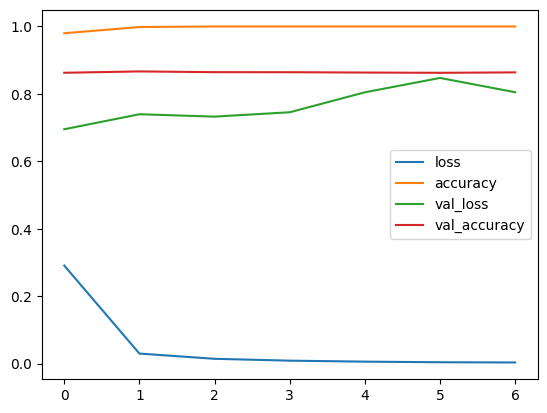

In [216]:
pd.DataFrame(history.history).plot()

In [217]:
load_model = create_model()

In [218]:
load_model.load_weights("checkpoint/save-model/")

In [219]:
performance = load_model.evaluate(test)
print("Testing accuracy: ", performance[1])

250/250 [==============================] - 4s 13ms/step - loss: 0.7979 - accuracy: 0.8643
Testing accuracy:  0.8642799854278564


In [227]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=12)
    plt.yticks(fontsize=12)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=12)

In [221]:
y_pred = []
y_truth = []

In [224]:
for x, y in test:
    y_pred.extend(np.round(np.squeeze(load_model.predict([x], verbose=0))))
    y_truth.extend(y.numpy())

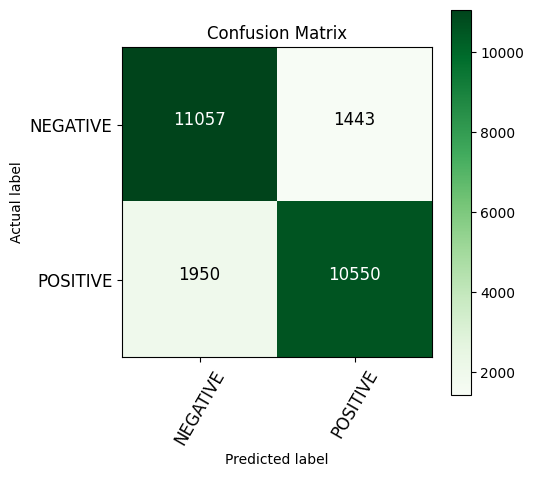

In [228]:
conf_matrix(y_test=y_truth, y_pred=y_pred, class_names=['NEGATIVE', 'POSITIVE'])
